In [1]:
import numpy as np
import matplotlib
import json
import pandas as pd
import os
from collections import defaultdict
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [2]:
def get_num_tokens(text):
    return len(word_tokenize(text))

In [3]:
# Build table for generating dataset statistics
splits = ["train", "valid_seen", "valid_unseen"]
task_fields = ["task_type", "focus_object", "base_object", "dest_object", "scene"]
data_path = "../tars/alfred/data/json_2.1.0"
stats_dict = defaultdict(lambda: [])

for split in splits:
    task_dirs = os.listdir("{}/{}".format(data_path, split))
    for i in tqdm(range(len(task_dirs))):
        task_dir = task_dirs[i]
        task_values = task_dir.split("-")
        for trial_dir in os.listdir("{}/{}/{}".format(data_path, split, task_dir)):
            stats_dict["split"].append(split)
            stats_dict["task_id"].append(trial_dir)

            for j, field in enumerate(task_fields):
                stats_dict[field].append(task_values[j])

            traj_data_file = open("{}/{}/{}/{}/traj_data.json".format(data_path, split, task_dir, trial_dir))
            traj_data = json.load(traj_data_file)
            num_steps_list = []
            num_step_tokens_list = []
            num_task_tokens_list = []

            for directive in traj_data["turk_annotations"]["anns"]:
                num_steps_list.append(len(directive["high_descs"]))
                num_step_tokens_list.append(sum([get_num_tokens(desc) for desc in directive["high_descs"]]))
                num_task_tokens_list.append(get_num_tokens(directive["task_desc"]))

            stats_dict["steps"].append(np.mean(num_steps_list))
            stats_dict["total_steps_toks"].append(np.mean(num_step_tokens_list))
            stats_dict["task_toks"].append(np.mean(num_task_tokens_list))
            stats_dict["images"].append(len(traj_data["images"]))
            stats_dict["actions"].append(len(traj_data["plan"]["low_actions"]))
            nav_count = 0
            interact_count = 0

            for action in traj_data["plan"]["low_actions"]:
                if "mask" in action["discrete_action"]["args"].keys():
                    interact_count += 1
                else:
                    nav_count += 1
                    
            stats_dict["nav_actions"].append(nav_count)
            stats_dict["interact_actions"].append(interact_count)


stats_df = pd.DataFrame(stats_dict)

100%|██████████| 85/85 [00:01<00:00, 58.48it/s]


In [4]:
# Derive some additional columns
stats_df["toks/step"] = stats_df["total_steps_toks"] / stats_df["steps"]
stats_df["actions/step"] = stats_df["actions"] / stats_df["steps"]
stats_df["images/action"] = stats_df["images"] / stats_df["actions"]
stats_df["nav/interact"] = stats_df["nav_actions"] / stats_df["interact_actions"]

stats_df = stats_df.round(2)


In [5]:
stats_df

,split,task_id,task_type,focus_object,base_object,dest_object,scene,steps,total_steps_toks,task_toks,images,actions,nav_actions,interact_actions,toks/step,actions/step,images/action,nav/interact
0,train,trial_T20190908_081542_564499,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,84.33,10.33,222,40,36,4,12.05,5.71,5.55,9.00
1,train,trial_T20190908_081608_404049,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,76.67,12.33,180,28,24,4,10.95,4.00,6.43,6.00
2,train,trial_T20190908_081632_840019,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,79.33,13.00,213,40,36,4,11.33,5.71,5.32,9.00
3,train,trial_T20190907_181551_510121,pick_cool_then_place_in_recep,Cup,None,Shelf,1,6.0,95.33,13.00,378,79,71,8,15.89,13.17,4.78,8.88
4,train,trial_T20190907_181654_244229,pick_cool_then_place_in_recep,Cup,None,Shelf,1,6.0,69.33,8.00,314,56,48,8,11.56,9.33,5.61,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,valid_unseen,trial_T20190906_180922_517529,look_at_obj_in_light,Laptop,None,FloorLamp,219,4.0,43.17,9.33,153,25,22,3,10.79,6.25,6.12,7.33
7076,valid_unseen,trial_T20190906_181009_893506,look_at_obj_in_light,Laptop,None,FloorLamp,219,4.0,39.67,10.50,174,31,28,3,9.92,7.75,5.61,9.33
7077,valid_unseen,trial_T20190907_080730_211959,pick_clean_then_place_in_recep,Spatula,None,Drawer,10,6.0,75.67,11.00,266,41,33,8,12.61,6.83,6.49,4.12
7078,valid_unseen,trial_T20190907_080800_275989,pick_clean_then_place_in_recep,Spatula,None,Drawer,10,6.0,86.00,8.00,274,45,37,8,14.33,7.50,6.09,4.62


In [6]:
# Plot frequency of a categorical field. Useful for task_type and maybe objects.
def plot_freq(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    freq_cols = {split:stats_df[stats_df["split"] == split][col].value_counts(normalize=True) for split in splits}
    pd.concat(freq_cols, axis=1).plot.bar(xlabel=col, ylabel="Relative Frequency", **kwargs)

# Plot histogram of a quantitative field. 
def plot_hist(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    axes = stats_df.hist(col, by="split", sharex=True, **kwargs)
    for ax in axes.reshape(-1):
        ax.tick_params(axis="x", which="both", labelbottom=True)
        ax.set_xlabel(col, visible=True)
        ax.set_ylabel("Frequency")

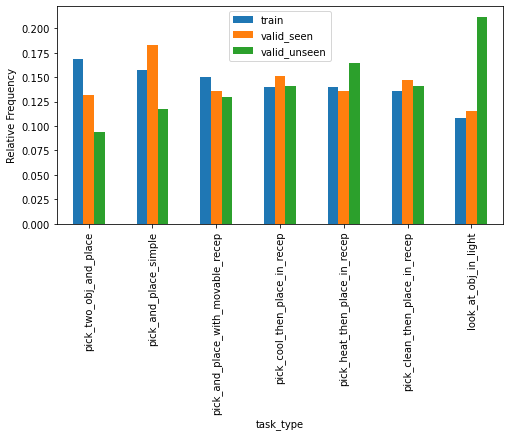

In [7]:
plot_freq("task_type", figsize=(8, 4))

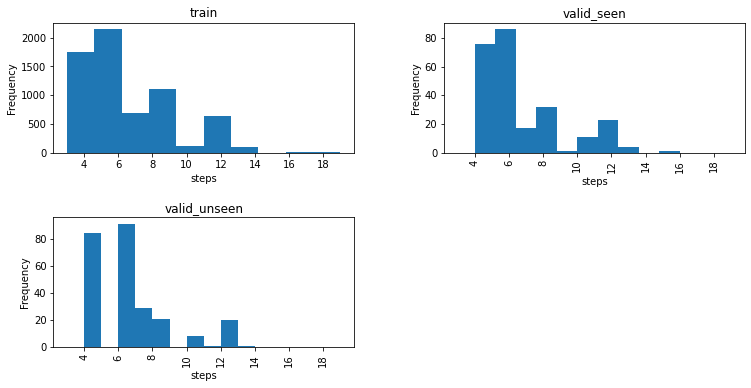

In [8]:
plot_hist("steps", figsize=(12, 6))

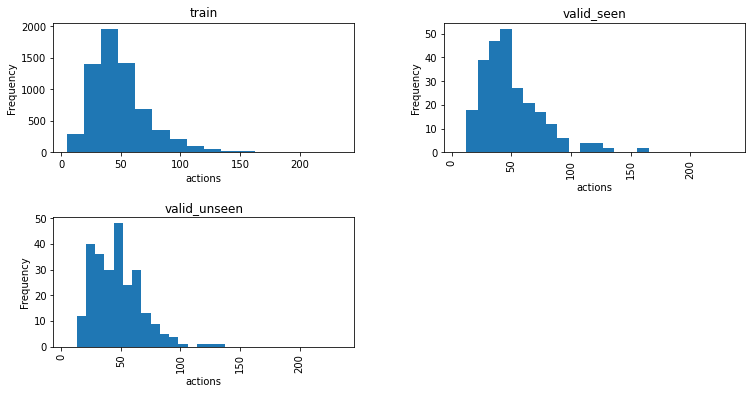

In [9]:
plot_hist("actions", figsize=(12, 6), bins=16)

In [11]:
stats_df.groupby('split').mean().round(2)

,steps,total_steps_toks,task_toks,images,actions,nav_actions,interact_actions,toks/step,actions/step,images/action,nav/interact
split,,,,,,,,,,,
train,6.68,81.88,10.02,286.75,49.78,43.34,6.44,12.39,7.60,6.08,9.19
valid_seen,6.64,80.20,10.09,287.24,50.12,43.60,6.52,12.18,7.72,6.02,9.25
valid_unseen,6.27,78.73,10.04,277.72,46.98,40.35,6.63,12.63,7.72,6.12,8.13


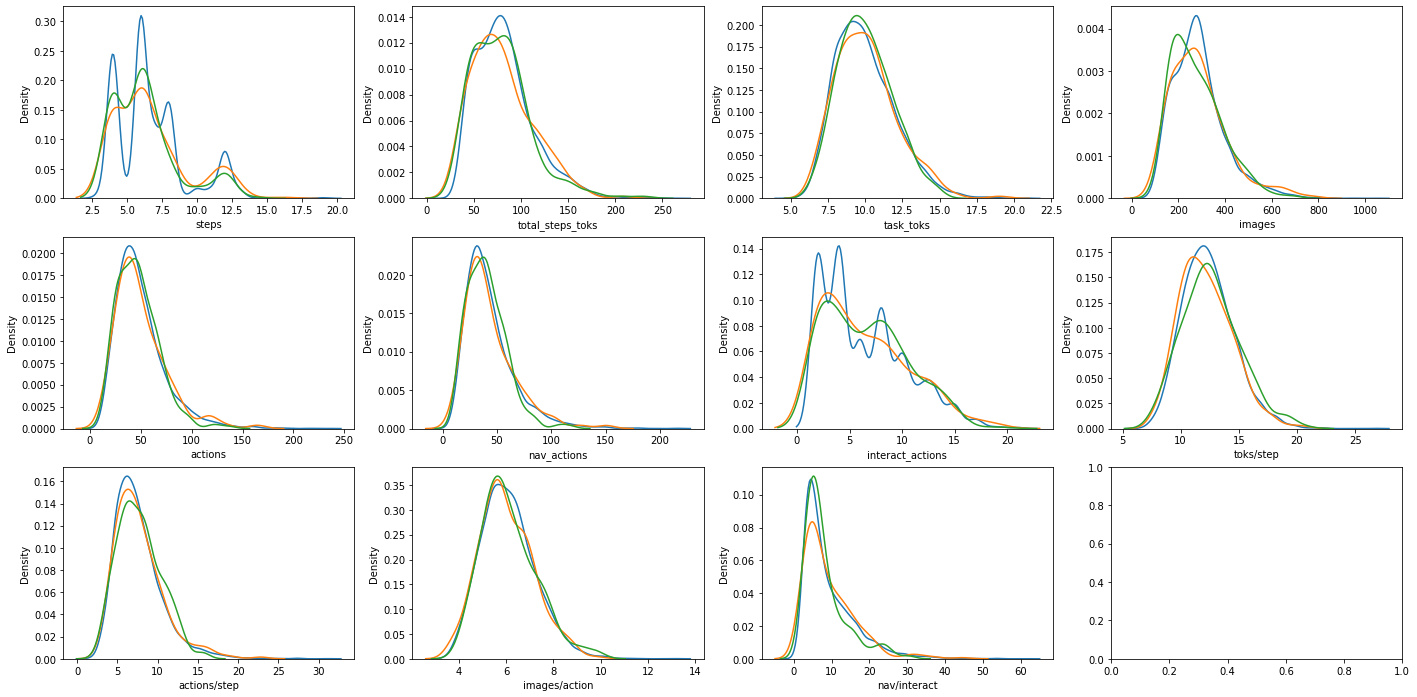

In [21]:
# inspired by https://stackoverflow.com/questions/46045750/python-distplot-with-multiple-distributions
import seaborn as sns
import math
import matplotlib.pyplot as plt

cs = [c for c in stats_df.columns if stats_df[c].dtype != 'O']
splits = stats_df['split'].unique()
df = stats_df[['split'] + cs].melt(['split'], var_name='cols', value_name='vals')
num_cols = 4
num_rows = math.ceil(len(cs) / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 12))

col = 0
for r in range(len(axs)):
    for c in range(len(axs[r])):
        if col >= len(cs):
            break
        for s in splits:
            sns.distplot(stats_df[stats_df['split'] == s][cs[col]], hist=False, rug=False, ax=axs[r][c])
        col += 1

